DotA 2 is a multiplayer online battle arena (MOBA) created by Valve. As of the time of this writing (1530 Central, 2021-04-27), there are currently 422,074 accounts currently playing with a peak of 599,256 individual accounts in the last 24 hours. Part of DotA 2's continued success is its boundless complexities. Each game consists of two teams of five with each player selecting a unique hero. There are 121 heroes to select from, meaning there are over 120 trillion potential hero combinations; This is before taking into account whether or not a hero selected is an ally or an enemy. Each hero can have six items at any time and there are 56 items that can be purchased individually and 96 items that are combinations of the 56 items. All of these possibilites are before including a few factors that are random chances each game.

With so many heroes and items, there are tiers of heroes and items that are considered better than others; the top two most selected heroes are picked by a player in over 25% of games while the two least popular heroes are picked in less than 1% of games. Similarly, some items are good on all heroes while others are only good on a few. Given the sheer number of heroes and items, how does one balance the game?

Quite simply, it's impossible to do so, at least perfectly. In a perfect system, regardless of what hero combination is in the game, each team would have a 50% chance of winning. Instead, it's more of a rock-paper-scissors system, or maybe more of a RPS25 system, as shown here (created and copyrighted by David C. Lovelace).

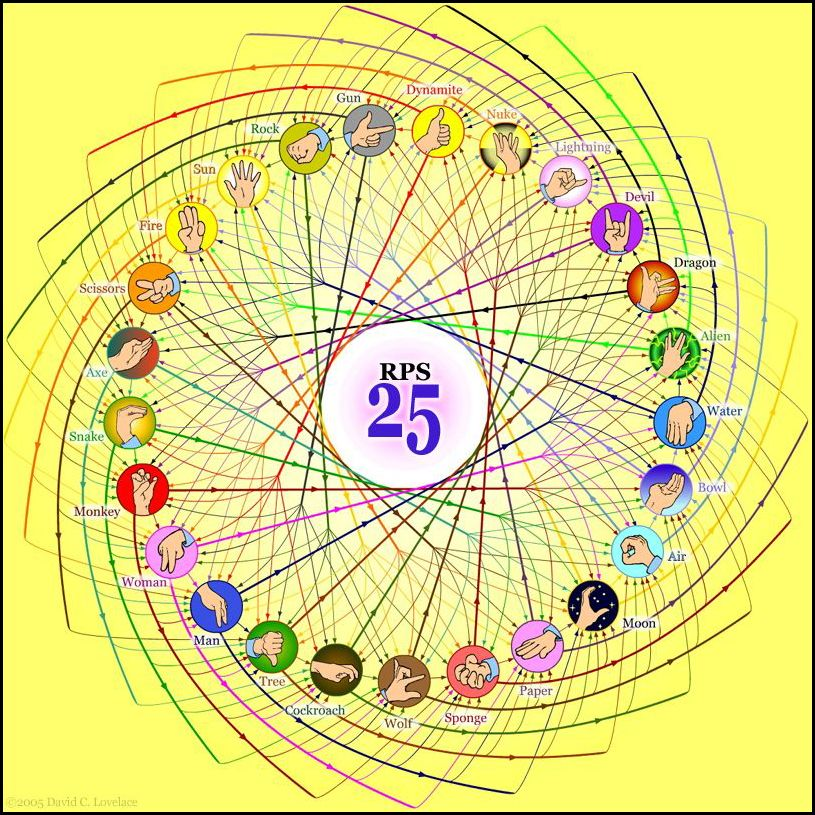
<center><a href>https://www.umop.com/rps25.htm<a></center>

In the RPS25 system, every entry has 12 winning outcomes, 12 losing outcomes, and 1 potential draw, making it perfectly balanced (assuming you replay and ignore the draws) at a 50% chance of winning and a 50% chance of losing. Now, imagine if instead of being 12/12/1, it was 6/6/13. In this instance, an entry would have a 24% chance of winning, 24% chance of losing, and a 52% chance of drawing. DotA 2 works largely this way with Hero A with Item A winning against Hero B, losing to Hero C with Item C, and being a relatively equal matchup to heroes D through Z.<br><br>
There are a number of axes that the game is balanced on. Each item costs gold (and differing amounts at that), so heroes that are item dependent require significantly more gold than heroes that aren't, meaning a hero that doesn't require gold can spend time making sure the hero that needs gold doesn't get it. Some heroes use only physical attacks, meaning they're weak against heroes that either have high defense or a significant health pool. Some heroes are very strong in the early game but don't scale well, meaning heroes that start out a little weaker but get stronger at a better rate will eventually start winning, assuming the match goes long enough to reach that tipping point. These are only a few of the axes available. The changes can be as subtle as removing a single tree from among 12 along a path to give heroes slightly better vision of potential enemies.<br><br>
So what does this capstone intend to do? The team in charge of balancing DotA has stated their goal is to make each hero viable in competitive play, but as noted above, the most selected hero is selected 50 times more often than the least selected hero. By using machine learning, we can create a database with thousands of matches -- currently around 30,000 matches or 7 GB, though there is purportedly 20 TBs of match data at Valve -- to see if certain trends emerge, like if Hero A with Item A has a very high win rate or if Hero B is actually an effective counter to Hero A. Analyzing the various situations across matches can not only help determine whether a change is needed but also if a change had the intended effect.

As a note, this program is still in its infancy. Currently, I am only viewing whether or not a hero was selected and whether that team won or not. Further analysis is possible (such as if heroes got items by a certain time or what area of the map each hero started on) but at my current skill level such a build would take longer than I currently have available.

The data gathering can be found <a href = https://github.com/CasualChemist/projects/blob/main/DSF_Capstone_4/Final_Capstone_Data_Gathering.ipynb>here</a> and the data cleaning and feature engineering can be found <a href = https://github.com/CasualChemist/projects/blob/main/DSF_Capstone_4/Final_Capstone_Data_Cleaning_and_Feature_Engineering_Simple.ipynb>here</a>

In [1]:
#import the necessities
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import joblib
import math
import warnings
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression, LinearRegression
from dask_ml.xgboost import XGBClassifier, XGBRegressor
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression as logr
from sklearn.linear_model import LinearRegression as linr
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import mse, rmse
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#create a client
##while all of these models could likely be made in pandas, I want to
##eventually incorporate more data into it, eventually necessitating more
##computers, so all of the tests were run in Dask.
client = Client(n_workers=2, threads_per_worker=2, memory_limit='12GB')
client

Client Scheduler: tcp://127.0.0.1:60680 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 24.00 GB


In [3]:
#call the dataset
df = dd.read_csv('D:/DSF Files/simpledotaset.txt', sep='\t')

In [4]:
#confirm the data
df.head()

,matches,game_mode,duration,lobby_type,radiant_win,patch,start_time,Radiant: Abaddon,Radiant: Alchemist,Radiant: Ancient Apparition,...,Dire: Void Spirit,Dire: Warlock,Dire: Weaver,Dire: Windranger,Dire: Winter Wyvern,Dire: Witch Doctor,Dire: Wraith King,Dire: Zeus,Radiant Abandon,Dire Abandon
0,5968250483,2,2006,1,False,48,1619579919,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5968198971,2,1760,1,False,48,1619575457,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5968163525,2,1892,1,False,48,1619571736,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5968112278,2,2281,1,True,48,1619565919,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5968064626,2,2317,1,False,48,1619561082,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that the data has been called, many supervised learning models will be checked. The ones with the best results will be hypertuned if applicable and used for a few extra tests.

In [5]:
#matchid, game_mode, lobby_type, and start_time were all included as
#identifiers and should be removed here
df = df.drop(['matches', 'game_mode', 'lobby_type', 'start_time', 'patch'], 1)
#create a feature set, target set, and split them
x = df.drop(['radiant_win'], 1)
y = df['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=357)

In [6]:
#now we start running all of the tests, starting with random forest
#min_samples_leaf was set at 10 because, otherwise, the model continues until
#the roc_auc score becomes 1.
model = RandomForestClassifier(min_samples_leaf = 10)
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([10.90982938, 10.91681862,  9.91349983, 11.01353002, 10.37928724]),
 'score_time': array([0.04185772, 0.04687476, 0.0977397 , 0.03690219, 0.0398612 ]),
 'test_score': array([0.54392649, 0.5294777 , 0.54898005, 0.55032504, 0.54696256])}

0.7829994571115511


In [7]:
#for some reason, using dask's built in ml kits don 't seem to work well for me
#but I try them here anyway.
model = LogisticRegression()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.07975841, 4.81680298, 4.54652619, 4.44479918, 0.08178139]),
 'score_time': array([0.        , 0.00698161, 0.0079782 , 0.0099721 , 0.        ]),
 'test_score': array([       nan, 0.52566689, 0.54113427, 0.54404842,        nan])}

0.5691870708500294


In [8]:
#this one tells me to designate chunks but, given that I'm pulling from a single
#dataframe, the chunks don't need to be set? it's something to investigate later.
model = LinearRegression()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

ValueError: You must specify a chunks= keyword argument.
This specifies the chunksize of your array blocks.

See the following documentation page for details:
  https://docs.dask.org/en/latest/array-creation.html#chunks

In [9]:
#same as above, dask's xgboost doesn't seem to work well
model = XGBClassifier()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
display(scores)

{'fit_time': array([0.01595807, 0.01792359, 0.01894903, 0.01894903, 0.01396251]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan])}

In [10]:
#same as above, dask's xgboost doesn't seem to work well
model = XGBRegressor()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
display(scores)

{'fit_time': array([0.02296638, 0.01595879, 0.02291393, 0.02991843, 0.02293754]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan])}

In [11]:
#given the fact that random forest above did well, we can expect
#this one to do well too. still, confirmation is always good
model = DecisionTreeRegressor(min_samples_leaf=10)
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.85468793, 0.86568522, 0.82279849, 0.90760112, 0.6351099 ]),
 'score_time': array([0.00299168, 0.00398922, 0.00299215, 0.00299191, 0.00299072]),
 'test_score': array([-0.21358905, -0.24649938, -0.19812696, -0.22765934, -0.23591529])}

0.8008050866587911


In [12]:
#sklearn's logistic regression gives us approximately the same result but without the NaNs
model = logr()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([1.16047215, 1.25322366, 1.24222589, 1.31505847, 1.34198642]),
 'score_time': array([0.00498748, 0.00698137, 0.00698185, 0.00598407, 0.004987  ]),
 'test_score': array([0.53563424, 0.51132033, 0.54292759, 0.54561757, 0.52970186])}

0.5656451839278006


In [13]:
#sklearn's OLS works objectively better since it actually works but isn't particularly useful
model = linr()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.13278723, 0.23636794, 0.22539687, 0.14660287, 0.23537111]),
 'score_time': array([0.00299239, 0.00498676, 0.00398898, 0.00398922, 0.00398898]),
 'test_score': array([-0.00532588, -0.00306112,  0.0061085 ,  0.00734553, -0.00488505])}

0.5993341380245124


In [14]:
#lasso does okay but the R^2 value is low and the auc is poor
model = Lasso()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.10668564, 0.09075737, 0.11765456, 0.1146636 , 0.12163615]),
 'score_time': array([0.00897598, 0.00299287, 0.00797892, 0.00598383, 0.00398922]),
 'test_score': array([-0.0009925 , -0.00071932, -0.00114764,  0.00026926,  0.00214597])}

0.521310554947709


In [15]:
#same as lasso
model = Ridge()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.10866189, 0.10666728, 0.11566186, 0.11167216, 0.06382942]),
 'score_time': array([0.00598407, 0.00598383, 0.00598407, 0.004987  , 0.00349593]),
 'test_score': array([-0.00522831, -0.00302365,  0.00615373,  0.00740374, -0.00478943])}

0.5993362348181576


In [16]:
#same as lasso and ridge
model = ElasticNet()
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.09275222, 0.11167216, 0.1066854 , 0.1216464 , 0.10170007]),
 'score_time': array([0.00398946, 0.01296568, 0.00698209, 0.00398898, 0.00997233]),
 'test_score': array([-0.0009597 , -0.0007971 , -0.0011913 ,  0.00027686,  0.00226696])}

0.521310554947709


The decision trees work very well and the logistic regression is the best of the rest. Conveniently, both of those can be hypertuned and feature importances can be found.. kind of. Random Forest has a percentage based feature_importance scale while logistic regression has coefficients which are a little harder to interpret.<br><br>
As a note, I try SelectFromModel again but have never been able to get it to work. I've included the code below in case someone can correct whatever I've done wrong.

In [17]:
#hypertuning random forest using 10 per leaf and warm_start to decrease time
#and computational power needed
rf_model = RandomForestClassifier(warm_start=True, min_samples_leaf=10)

rf_params = {"max_depth": [20, 30, 40, 50, 60], 'n_estimators': [50, 100, 150, 200]}

grid_search_rf = GridSearchCV(rf_model,
                           rf_params,
                           return_train_score=True,
                           iid=True,
                           cv=5, 
                           scoring='roc_auc')

In [18]:
#check the results
with joblib.parallel_backend('dask'):
    grid_search_rf.fit(x_train.compute(), y_train.compute())
print(grid_search_rf.best_params_)

{'max_depth': 30, 'n_estimators': 150}


In [19]:
#repeat with logistic regression
rf_model = logr()

rf_params = {'C': [0.01, 0.1, .25, .5, 1, 3, 5, 10], 'penalty': ['l2', 'None']}

grid_search_rf = GridSearchCV(rf_model,
                           rf_params,
                           return_train_score=True,
                           iid=True,
                           cv=5, 
                           scoring='roc_auc')

In [20]:
#check the results
with joblib.parallel_backend('dask'):
    grid_search_rf.fit(x_train.compute(), y_train.compute())
print(grid_search_rf.best_params_)

{'C': 5, 'penalty': 'l2'}


In [21]:
#logr has parameters that don't lend themselves to a traditional
#param grid, so I chose another possibility of solver and penalty
#to check C with
rf_model = logr(solver='liblinear', penalty='l1')

rf_params = {'C': [0.01, 0.1, .25, .5, 1, 3, 5, 10]}

grid_search_rf = GridSearchCV(rf_model,
                           rf_params,
                           return_train_score=True,
                           iid=True,
                           cv=5, 
                           scoring='roc_auc')

In [22]:
with joblib.parallel_backend('dask'):
    grid_search_rf.fit(x_train.compute(), y_train.compute())
print(grid_search_rf.best_params_)

{'C': 0.5}


In [23]:
#run the model with the tuned parameters
model = RandomForestClassifier(max_depth=40, min_samples_leaf = 10, n_estimators = 150)
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([14.79628706, 12.89101052, 13.94675565, 14.32876277, 14.70223212]),
 'score_time': array([0.06578732, 0.10372257, 0.09775996, 0.05738449, 0.03700924]),
 'test_score': array([0.54728821, 0.52992603, 0.55323918, 0.55279085, 0.54292759])}

0.763183710780471


In [24]:
#run this model with the tuned parameters
model = logr(C = 10)
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([1.33756781, 1.35950708, 1.28766298, 1.35146189, 1.40737987]),
 'score_time': array([0.0039897 , 0.00398922, 0.00598454, 0.00649285, 0.00398946]),
 'test_score': array([0.53541013, 0.51647613, 0.54763506, 0.54337592, 0.52970186])}

0.565654601388702


In [25]:
#run another model with the tuned parameters
model = logr(solver='liblinear', penalty='l1', C=0.25)
with joblib.parallel_backend('dask'):
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_pred = model.predict(x_train.values.compute())
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

{'fit_time': array([0.27927852, 0.27128482, 0.27329469, 0.24387336, 0.18106651]),
 'score_time': array([0.0039897 , 0.00299215, 0.00398993, 0.00250101, 0.00296092]),
 'test_score': array([0.5289108 , 0.51961444, 0.5460659 , 0.5460659 , 0.53822013])}

0.5703019613858507


In [26]:
#SelectFromModel refuses to work for me
with joblib.parallel_backend('dask'):
    model = RandomForestClassifier(max_depth=50, min_samples_leaf=15)
    sfm = SelectFromModel(estimator=model.fit(x_train, y_train))
    sfm.feature_importances_.coef_

AttributeError: 'SelectFromModel' object has no attribute 'feature_importances_'

In [27]:
#regardless if I try feature_importances_ or coef_
with joblib.parallel_backend('dask'):
    model = RandomForestClassifier(max_depth=50, min_samples_leaf=15)
    sfm = SelectFromModel(estimator=model.fit(x_train, y_train))
    sfm.estimator_.coef_

AttributeError: 'SelectFromModel' object has no attribute 'estimator_'

In [28]:
#we use feature_importances_ as given by rfc. the 0.04 threshold is arbitrary
with joblib.parallel_backend('dask'):
    model = RandomForestClassifier(max_depth=40, min_samples_leaf=10, n_estimators=150)
    fitted = model.fit(x_train.values.compute(), y_train.values.compute())
    importances = fitted.feature_importances_
    for i in range(len(x_train.columns)):
        if importances[i] > 0.04:
            print('{}: {}'.format(x_train.columns[i], importances[i]))

duration: 0.1108582645404983


In [29]:
#coef_ is harder to interpret but the 0.04 threshold is also arbitrary
with joblib.parallel_backend('dask'):
    model = logr(C = 10)
    fitted = model.fit(x_train, y_train)
    importance = fitted.coef_[0]
    for i in range(len(x_train.columns)):
        if importances[i] > 0.04:
            print('{}: {}'.format(x_train.columns[i], importances[i]))

duration: 0.1108582645404983


In [30]:
#create a feature set, target set, and split them
x = df.drop(['radiant_win'], 1)
y = df['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=357)

In [31]:
model = RandomForestClassifier(max_depth=40, min_samples_leaf = 10, n_estimators = 150)
with joblib.parallel_backend('dask'):
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_train_predictions = fit.predict(x_train.values.compute())
    y_test_predictions = fit.predict(x_test.values.compute())
    print("R-squared of the model in the training set is: {}".format(model.score(x_train, y_train)))
    print("AUC Score of the model in the training set is: {}".
          format(roc_auc_score(y_train.values.compute(), y_train_predictions)))
    print("R-squared of the model in the test set is: {}".format(model.score(x_test, y_test)))
    print("AUC Score of the model in the test set is: {}".
          format(roc_auc_score(y_test.values.compute(), y_test_predictions)))

R-squared of the model in the training set is: 0.7699273738007711
AUC Score of the model in the training set is: 0.766085902585028
R-squared of the model in the test set is: 0.5465944107958771
AUC Score of the model in the test set is: 0.5445426620238473


In [32]:
model = logr(C = 10)
with joblib.parallel_backend('dask'):
    fit = model.fit(x_train.values.compute(), y_train.values.compute())
    y_train_predictions = fit.predict(x_train.values.compute())
    y_test_predictions = fit.predict(x_test.values.compute())
    print("R-squared of the model in the training set is: {}".format(model.score(x_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(model.score(x_test, y_test)))
    print("AUC Score of the model in the training set is: {}".
          format(roc_auc_score(y_train.values.compute(), y_train_predictions)))
    print("R-squared of the model in the test set is: {}".format(model.score(x_test, y_test)))
    print("AUC Score of the model in the test set is: {}".
          format(roc_auc_score(y_test.values.compute(), y_test_predictions)))

R-squared of the model in the training set is: 0.5683224244597866
R-squared of the model in the test set is: 0.5392625650834131
AUC Score of the model in the training set is: 0.565654601388702
R-squared of the model in the test set is: 0.5392625650834131
AUC Score of the model in the test set is: 0.5382062534234588


Neither of the test scores are particularly great, though that's what I was hoping to see. If there was a trend that guaranteed winning or losing, it would be a problem for the game. The R^2 value is to be expected since all but one column (duration) is binary. Given the fact that feature importances are easier to iterpret and that the training set has better values, Random Forest will be used. However, because of the relatively low time and computational investment, I'll indulge logistic regression for the rest of this notebook.

Having a working model for all heroes, I want to see if I can use this to find trends based on a parameter. For instance, one of the heroes is named Huskar. I want to see if there are any particular factors that contribute to the win rate for Huskar, such as having a certain hero as an ally or an enemy,

In [33]:
#make specific dfs with Huskar
specific_dire = df[df['Dire: Huskar'] == 1]
specific_radiant = df[df['Radiant: Huskar'] == 1]
print('Number of games with Huskar on the Radiant team: {}.'.format(len(specific_radiant)))
print('Number of games with Huskar on the dire team: {}.'.format(len(specific_dire)))

Number of games with Huskar on the Radiant team: 396.
Number of games with Huskar on the dire team: 372.


In [34]:
#calculate the pick rate and the win rate for the selected hero
dummy_math_d = specific_dire[specific_dire['radiant_win'] == 0]
dummy_math_r = specific_radiant[specific_radiant['radiant_win'] == 1]
win_rate = ((len(dummy_math_d) + len(dummy_math_r))/
           (len(specific_dire) + len(specific_radiant)))
pick_rate = ((len(specific_dire) + len(specific_radiant))/
             len(df))
print('Win rate is {:.02f}%.'.format(win_rate*100))
print('Pick rate is {:.02f}%.'.format(pick_rate*100))

Win rate is 46.88%.
Pick rate is 2.42%.


In [35]:
#run the model and get results for Huskar
#because it's only regarding games for Huskar, the threshold for
#feature_importance is much higher
x = specific_radiant.drop(['radiant_win', 'Dire: Huskar', 'Radiant: Huskar'], 1)
y = specific_radiant['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=357)
print('Huskar: Radiant')
with joblib.parallel_backend('dask'):
    model = RandomForestClassifier(max_depth=40, min_samples_leaf = 10, n_estimators = 150)
    fitted = model.fit(x_train.values.compute(), y_train.values.compute())
    importances = fitted.feature_importances_
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    y_pred = model.predict(x_train.values.compute())
    for i in range(len(x_train.columns)):
        if importances[i] > 0.10:
            print('{}: {}'.format(x_train.columns[i], importances[i]))
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

x = specific_dire.drop(['radiant_win', 'Dire: Huskar', 'Radiant: Huskar'], 1)
y = specific_dire['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=357)
print('\nHuskar: Dire')
with joblib.parallel_backend('dask'):
    model = RandomForestClassifier(max_depth=40, min_samples_leaf = 10, n_estimators = 150)
    fitted = model.fit(x_train.values.compute(), y_train.values.compute())
    importances = fitted.feature_importances_
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    y_pred = model.predict(x_train.values.compute())
    for i in range(len(x_train.columns)):
        if importances[i] > 0.10:
            print('{}: {}'.format(x_train.columns[i], importances[i]))
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

Huskar: Radiant
duration: 0.1485302723418131


{'fit_time': array([2.24720192, 2.26353097, 2.52750587, 2.06287622, 2.31929183]),
 'score_time': array([0.02489018, 0.03491163, 0.02194118, 0.05385494, 0.04298711]),
 'test_score': array([0.390625  , 0.46875   , 0.57142857, 0.57142857, 0.53968254])}

0.704878534448427

Huskar: Dire
duration: 0.14377091562952743


{'fit_time': array([3.35313463, 2.23311615, 3.19455862, 2.92327332, 3.10526013]),
 'score_time': array([0.01994705, 0.02593088, 0.05385637, 0.02792525, 0.0498662 ]),
 'test_score': array([0.55      , 0.55      , 0.56666667, 0.55932203, 0.55932203])}

0.5318546914932457


In [36]:
#create a feature set, target set, and split them
x = specific_radiant.drop(['radiant_win', 'Dire: Huskar', 'Radiant: Huskar'], 1)
y = specific_radiant['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=357)
print('Huskar: Radiant')
with joblib.parallel_backend('dask'):
    model = logr(C = 10)
    fitted = model.fit(x_train, y_train)
    importance = fitted.coef_[0]
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    y_pred = model.predict(x_train.values.compute())
    for i in range(len(x_train.columns)):
        if importances[i] > 0.05:
            print('{}: {}'.format(x_train.columns[i], importances[i]))
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

#create a feature set, target set, and split them
x = specific_dire.drop(['radiant_win', 'Dire: Huskar', 'Radiant: Huskar'], 1)
y = specific_dire['radiant_win']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=357)
print('\nHuskar: Dire')
with joblib.parallel_backend('dask'):
    model = logr(C = 10)
    fitted = model.fit(x_train, y_train)
    importances = fitted.coef_[0]
    scores = cross_validate(model, x_train.values.compute(), y_train.values.compute(), cv=5)
    y_pred = model.predict(x_train.values.compute())
    for i in range(len(x_train.columns)):
        if importances[i] > 0.05:
            print('{}: {}'.format(x_train.columns[i], importances[i]))
display(scores)
print(roc_auc_score(y_train.values.compute(), y_pred))

Huskar: Radiant
duration: 0.14377091562952743


{'fit_time': array([0.21099544, 0.19703269, 0.25238991, 0.28680348, 0.23643255]),
 'score_time': array([0.        , 0.0039897 , 0.00099707, 0.00199413, 0.00099707]),
 'test_score': array([0.5       , 0.4375    , 0.58730159, 0.58730159, 0.55555556])}

0.9147152528872958

Huskar: Dire
Radiant: Arc Warden: 0.6008001750044923
Radiant: Batrider: 1.370475757969177
Radiant: Beastmaster: 2.2627688670295787
Radiant: Bloodseeker: 1.384668249445535
Radiant: Bounty Hunter: 0.4416991292307746
Radiant: Broodmother: 0.5778122367713671
Radiant: Chaos Knight: 0.4847236348493189
Radiant: Chen: 3.478139123898843
Radiant: Clinkz: 0.5524420950905226
Radiant: Clockwerk: 0.7054109778203771
Radiant: Dark Willow: 1.3717894820423848
Radiant: Dazzle: 0.729146633125542
Radiant: Death Prophet: 1.3279337845934458
Radiant: Disruptor: 0.9845234456046569
Radiant: Doom: 1.4026214703367885
Radiant: Drow Ranger: 1.0849975441308581
Radiant: Earthshaker: 1.2710899776523468
Radiant: Elder Titan: 1.3546739897281543
Radiant: Enchantress: 1.1136454167144243
Radiant: Grimstroke: 0.8851170024348889
Radiant: Keeper of the Light: 1.1654497799343055
Radiant: Legion Commander: 0.36545449939620617
Radiant: Lich: 1.211029172234672
Radiant: Lina: 1.0319690502652605
Radiant: Lone Dr

{'fit_time': array([0.20445275, 0.17453289, 0.20943832, 0.2054503 , 0.19647288]),
 'score_time': array([0.0009973 , 0.00199509, 0.0009973 , 0.0009973 , 0.        ]),
 'test_score': array([0.45      , 0.61666667, 0.48333333, 0.49152542, 0.55932203])}

0.9508488499452356


In conclusion, when using a RandomForestClassifier with a max_depth of 40, n_esimators of 150, and min_samples_leaf of 10, we can create a model that is robust against overfitting and works well with binary columns. If using the Random Forest becomes too taxing, Logistic Regression is an okay substitute.<br><br>
I mentioned above that I was happy to see that the AUC and R^2 values were around 50% for the test values. This is because, in theory, each team should have about a 50% chance of winning and the model correctly predicting the training values but not the test values confirms that there isn't a way to have a good fit, or in other words, when coupled with the lack of feature importances, there are no significant trends that are egregiously problematic. However, this is only the smallest of dives into the data, as 30,000 games is a small amount and only looking at the team composition is an incredibly small amount of information.<br><br>
For the individual hero models, it's good that they can work but unfortunate that the data is so small for them. As the data set becomes larger, it will become more viable.

In [37]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
